## Importando bibliotecas

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from matplotlib import style
from sklearn.linear_model import LinearRegression

In [3]:
style.use('seaborn-muted')

## Buscando dados

In [4]:
tickers = ['TOTS3.SA', '^BVSP']
dados = pd.DataFrame()

for ticker in tickers:
    dados[ticker] = yf.download(ticker, start='2020-01-01', end='2020-12-31')['Adj Close']
    
dados.tail()    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,TOTS3.SA,^BVSP
Date,,
2020-12-22,27.513096,116348.0
2020-12-23,27.662298,117857.0
2020-12-28,27.980598,119051.0
2020-12-29,27.910969,119475.0
2020-12-30,28.567465,119306.0


Calculando retorno simples

In [5]:
def retorno_simples(dados):
    retorno_simples = np.log(dados / dados.shift())
    retorno_simples.dropna(inplace=True)
    return retorno_simples

In [6]:
retorno_simples(dados).head()

,TOTS3.SA,^BVSP
Date,,
2020-01-03,0.021036,-0.007330
2020-01-06,-0.023062,-0.007068
2020-01-07,0.004194,-0.001850
2020-01-08,-0.013511,-0.003564
2020-01-09,0.016393,-0.002584


In [7]:
print(len(retorno_simples(dados)))

246


Calculando retorno acumulado

In [8]:
def retorno_acumulado(retorno_simples):
    retorno_acumulado = (1 + retorno_simples).cumprod()
    retorno_acumulado.dropna(inplace=True)
    #retorno_acumulado.iloc[0] = 1
    return retorno_acumulado

In [9]:
retorno_acumulado(retorno_simples(dados)).head()

,TOTS3.SA,^BVSP
Date,,
2020-01-03,1.021036,0.992670
2020-01-06,0.997488,0.985654
2020-01-07,1.001671,0.983830
2020-01-08,0.988138,0.980324
2020-01-09,1.004336,0.977791


## Método I: regressão linear simples 

Utilizando a biblioteca Statsmodels

In [10]:
Y = retorno_simples(dados)['TOTS3.SA'].values
x = retorno_simples(dados)['^BVSP'].values

Modelo de regressão linear

In [12]:
X = sm.add_constant(x)

In [13]:
modelo = sm.OLS(Y, X)

In [14]:
resultado = modelo.fit()

In [15]:
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     245.6
Date:                Thu, 11 Nov 2021   Prob (F-statistic):           9.11e-39
Time:                        10:03:30   Log-Likelihood:                 539.22
No. Observations:                 246   AIC:                            -1074.
Df Residuals:                     244   BIC:                            -1067.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.523      0.6

### Estimando a reta de regressão

Obtendo os coeficientes para poder criar a reta de regressão estimada.

In [16]:
coef_linear, coef_angular = resultado.params

In [17]:
reta = coef_linear + coef_angular * x

In [18]:
print(f'Beta: {np.round(coef_angular, 2)}')

Beta: 0.94


In [19]:
X = X.reshape(-1, 1)
print(len(X))

492


In [20]:
reta = reta.reshape(-1, 1)
print(len(reta))

246


Plotando o gráfico

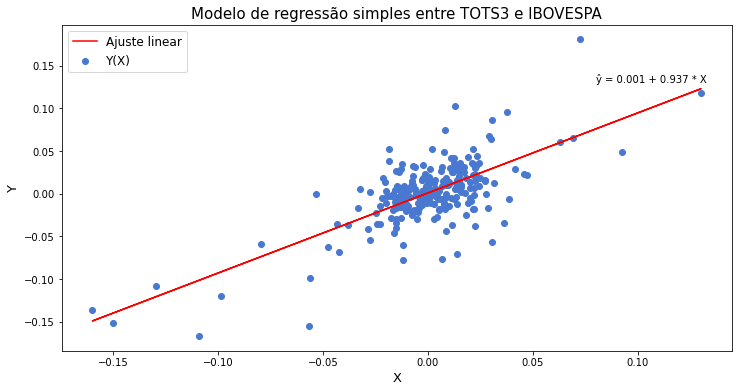

In [21]:
plt.figure(figsize=(12, 6));
plt.title('Modelo de regressão simples entre TOTS3 e IBOVESPA', fontsize=15);
plt.text(0.08, 0.13, f'ŷ = {np.round(coef_linear, 3)} + {np.round(coef_angular, 3)} * X')
plt.xlabel('X', fontsize=13);
plt.ylabel('Y', fontsize=13);
plt.scatter(x, Y, label='Dispersão dos dados');
plt.plot(x, reta, label='Reta de regressão', color='r');
plt.legend(loc=2, fontsize=12);

Utilizando a biblioteca Sklearn

In [28]:
x = retorno_simples(dados)['^BVSP'].values
y = retorno_simples(dados)['TOTS3.SA'].values

Mudando a o vetor x para um vetor 2D

In [29]:
X = x.reshape(-1, 1)

Ajustando o modelo

In [30]:
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

Buscando o coef. linear

In [31]:
reg.intercept_

0.0009046948983149272

Buscando o coef. angular

In [32]:
reg.coef_

array([0.93740336])

Grau de ajustamento do modelo

In [34]:
reg.score(X, y)

0.5016092501633601

Previsão do modelo: reta de regressão

In [35]:
y_chapeu = reg.predict(X)

Plotando o gráfico

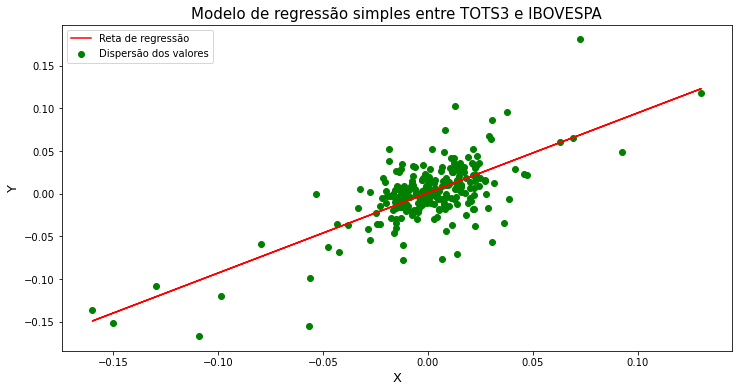

In [39]:
plt.figure(figsize=(12, 6));
plt.title('Modelo de regressão simples entre TOTS3 e IBOVESPA', fontsize=15);
plt.xlabel('X', fontsize=13);
plt.ylabel('Y', fontsize=13);
plt.plot(x, y_chapeu, label='Reta de regressão', color='r');
plt.scatter(x, y, label='Dispersão dos valores', color='green');
plt.legend(loc=2);


In [46]:
#sns.histplot((y - y_chapeu));

## Método II: calculo do beta

In [22]:
cov = retorno_simples(dados).cov() * 252
cov

,TOTS3.SA,^BVSP
TOTS3.SA,0.370860,0.198449
^BVSP,0.198449,0.211701


In [23]:
tots_ibov = cov.iloc[0,1]
tots_ibov

0.19844908329063493

In [24]:
var = retorno_simples(dados)['^BVSP'].var() * 252
var

0.2117008450799167

In [25]:
beta = tots_ibov / var

In [26]:
print(f'Beta: {np.round(beta, 2)}')

Beta: 0.94


SCRIP INCOMPLETO!